## Spectral grid fitting for the SALT spectra

We could do this with BT-Settl

The spectra are available here, on a one-by-one basis:

http://svo2.cab.inta-csic.es/theory/newov2/index.php?models=bt-settl


The spectra then need to be rotationally broadened. The broadening can be done with the eniric python package:

https://eniric.readthedocs.io/en/latest/

and the sampling to the instrument resolution of SALT's spectrograph can be done with a native astropy tool via "convolve":

https://docs.astropy.org/en/stable/convolution/


CARMENES spectra:

http://carmenes.cab.inta-csic.es/gto/jsp/reinersetal2018.jsp

In [275]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from astropy.io import fits
from astropy.constants import R_sun, c

from scipy import interpolate

# Get spectra

In [463]:
dirr = "/home/ekaterina/Documents/001_science/MalachiteMountains/data"
sp1 = pd.read_csv(f"{dirr}/salt/R202002090014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
model = pd.read_csv(f"{dirr}/btsettl/2700K.tsv", delimiter="\s+", skiprows=10, names=["lambd","flux"])
sp2 = pd.read_csv(f"{dirr}/salt/R202002080017.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
sp3 = pd.read_csv(f"{dirr}/salt/R202002080014.1.ffc.hwl.txt", delimiter="\s+", names=["lambd","flux","flux_err"])
from astropy.io import fits
hdu = fits.open(f"{dirr}/carmenes/carmenes_cnleo_vis.fits")

lambd = hdu[4].data.flatten().byteswap().newbyteorder()
flux = hdu[1].data.flatten().byteswap().newbyteorder()
sp4 = pd.DataFrame({"lambd":lambd, "flux":flux}).sort_values(by="lambd", ascending=True)
sp4 = sp4.dropna(how="any")

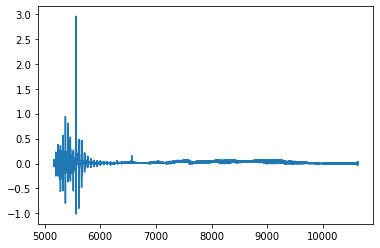

In [464]:
plt.plot(sp4.lambd, sp4.flux)

# Pick spectral regions

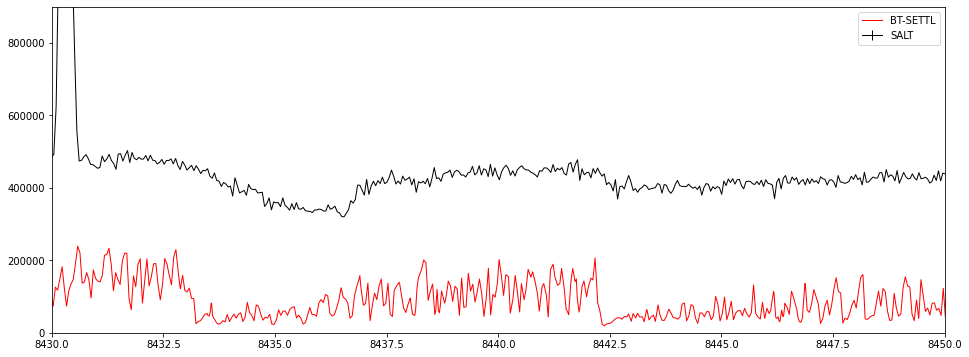

In [370]:
plt.figure(figsize=(16,6))
plt.errorbar(sp.lambd, sp.flux*5e7+.1e6, 
             yerr=sp.flux_err, c="k", linewidth=1, label="SALT")
plt.plot(model.lambd, model.flux, 
              c="r", linewidth=1, label="BT-SETTL")
plt.xlim(7695, 7705)
plt.xlim(8431,8450)
plt.ylim(-100,.9e6)
plt.legend();

In [108]:
mask = pd.read_csv(f"{dirr}/salt/no_tellur_regions.csv")
mask

,wavmin,wavmax
0,7680,7720
1,7750,8100
2,7000,7200
3,7330,7550
4,8380,8800


In [426]:
wavmin, wavmax = mask.wavmin[2], mask.wavmax[2]
sp = sp2
wav = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"lambd"].values
mflux = model.loc[(model.lambd>wavmin) & (model.lambd<wavmax),"flux"].values

wav.shape, sflux.shape


((4379,), (400,))

In [418]:
sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
f = interpolate.interp1d(swav, sflux,fill_value="extrapolate")
sfluxinterp = f(wav)

# Rotational broadening

[see eniric docs](https://eniric.readthedocs.io/en/latest/broadening.html#rotational-broadening)

In [406]:
from eniric import broaden

In [449]:
vsinis = np.arange(5,150,5)
vsinis

array([  5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,
        70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145])

In [439]:
#specs = pd.DataFrame({"wav":wav})

for vsini in vsinis:
    specs[vsini] = broaden.rotational_convolution(wav, model.lambd, model.flux, vsini)



100%|██████████| 4379/4379 [00:07<00:00, 584.08it/s]

100%|██████████| 4379/4379 [00:05<00:00, 755.64it/s]

100%|██████████| 4379/4379 [00:06<00:00, 683.37it/s]

100%|██████████| 4379/4379 [00:05<00:00, 772.85it/s]

100%|██████████| 4379/4379 [00:05<00:00, 756.07it/s]

  0%|          | 0/4379 [00:00<?, ?it/s]


100%|██████████| 4379/4379 [00:05<00:00, 817.44it/s]

100%|██████████| 4379/4379 [00:06<00:00, 698.73it/s]

100%|██████████| 4379/4379 [00:06<00:00, 686.17it/s]


In [446]:
#specs.to_csv(f"../../data/eniric/{wavmin}_{wavmax}_settl7.csv")#,index=False)
specs = pd.read_csv(f"../../data/eniric/{wavmin}_{wavmax}_settl7.csv")
specs = specs.set_index("wav")
specs

,5,10,15,20,25,30,35,40,45,50,...,100,105,110,115,120,125,130,135,140,145
wav,,,,,,,,,,,,,,,,,,,,,
7000.02,27759.542168,32250.361440,35257.898969,39356.049896,39644.580033,39844.707419,39323.369929,38974.673028,38923.396500,39038.580690,...,37525.329754,37784.570884,37899.514504,37988.344512,37909.639767,37907.259302,37959.858570,37918.976858,37873.494834,37794.613334
7000.07,39714.764225,35992.634618,36943.556828,39457.964986,39599.988232,40388.307493,39473.353774,39026.182385,39153.778990,39341.196571,...,37566.064947,37697.168279,37865.773919,37949.296545,37906.416087,37941.683835,37987.248397,37971.205440,37882.057836,37827.404773
7000.12,48958.161955,39141.330014,38492.049681,38973.853806,40212.008360,40534.675051,39766.120643,39283.076347,39461.375699,39526.215381,...,37593.974903,37671.744648,37832.066091,37882.410463,37936.940406,37976.902626,37980.545414,37998.038245,37894.428783,37837.078429
7000.17,50970.616428,43975.084023,41323.541366,38912.179462,40562.985557,40185.454494,39811.855870,39555.594308,39685.232640,39729.550113,...,37562.518513,37670.141135,37762.072500,37811.309015,37957.342970,38001.422387,38009.432007,38003.688386,37926.616556,37847.989583
7000.22,45469.315110,47743.320483,42701.325145,39901.455580,40342.140713,40269.469662,39963.208516,39974.787206,39951.432060,39831.575530,...,37581.443910,37655.970955,37677.120847,37772.457889,37945.475184,38022.154744,38030.559597,37982.074175,37948.342508,37882.281473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7199.76,11855.199675,12107.371194,14464.149016,16799.036956,17278.575439,18227.370823,18613.078271,19098.992251,19241.057792,19297.867855,...,19383.087735,19400.610848,19361.787761,19365.230370,19414.805212,19471.343953,19509.857446,19483.218603,19485.954954,19504.802014
7199.81,11931.375937,11915.307107,13877.653399,16590.834916,17233.879037,17450.296857,18376.948903,18972.199523,19152.633508,19312.349120,...,19604.380464,19551.563571,19506.204841,19518.373708,19566.348317,19606.071041,19614.128703,19569.348323,19554.926551,19572.955043
7199.86,12222.592427,12268.935118,14008.940125,16003.070308,17036.413161,16997.620828,18092.730344,18754.946457,19040.240619,19367.048039,...,19809.965593,19709.876073,19669.766772,19674.091700,19706.774463,19736.897128,19706.224777,19675.779383,19639.885955,19666.647437


In [447]:
from scipy.signal import correlate

In [456]:
# convert wavelength to difference in velocity
l0 = wav[int(len(wav)/2)]
v = ((wav-l0)/wav * c).to("km/s")
wav[1:100], v[1:100]

(array([7000.07, 7000.12, 7000.17, 7000.22, 7000.27, 7000.32, 7000.37,
        7000.42, 7000.47, 7000.52, 7000.57, 7000.62, 7000.67, 7000.72,
        7000.77, 7000.82, 7000.82, 7000.87, 7000.88, 7000.91, 7000.92,
        7000.94, 7000.96, 7000.97, 7000.99, 7001.02, 7001.05, 7001.07,
        7001.12, 7001.16, 7001.22, 7001.27, 7001.31, 7001.36, 7001.41,
        7001.47, 7001.52, 7001.56, 7001.61, 7001.66, 7001.72, 7001.77,
        7001.81, 7001.86, 7001.91, 7001.97, 7002.02, 7002.06, 7002.11,
        7002.16, 7002.22, 7002.27, 7002.31, 7002.36, 7002.41, 7002.47,
        7002.52, 7002.56, 7002.61, 7002.66, 7002.72, 7002.77, 7002.81,
        7002.86, 7002.91, 7002.97, 7003.02, 7003.06, 7003.11, 7003.16,
        7003.22, 7003.27, 7003.31, 7003.36, 7003.41, 7003.47, 7003.52,
        7003.56, 7003.61, 7003.66, 7003.72, 7003.77, 7003.81, 7003.86,
        7003.91, 7003.97, 7004.02, 7004.06, 7004.11, 7004.16, 7004.22,
        7004.27, 7004.27, 7004.31, 7004.36, 7004.41, 7004.47, 7004.52,
      

Text(0, 0.5, 'cross-correlation function')

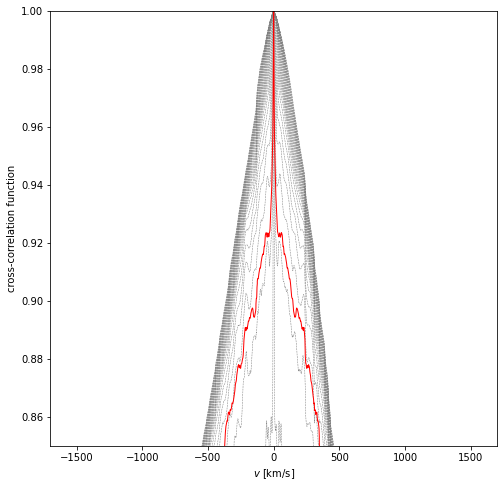

In [487]:
corrf = pd.DataFrame({"v":v})
plt.figure(figsize=(8,8))

for vsini, broad_spectrum in zip(vsinis, specs):
    # Convolve data
    if vsini>0:
        corr = correlate(specs[broad_spectrum],mflux, mode="same")
        me = np.max(corr)
        corrf[vsini] = corr/me
        plt.plot(v, corr/me, c="grey", linewidth=0.5,linestyle="dashed",label=f"{vsini} km/s")
# corr = correlate(mflux,mflux, mode="same")
# me = np.max(corr)
# plt.plot(v,corr/me, c="grey", linewidth=0.5,label=f"0 km/s")
for sp in [sp4]:
    sflux = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"flux"].values
    swav = sp.loc[(sp.lambd>wavmin) & (sp.lambd<wavmax),"lambd"].values
    f = interpolate.interp1d(swav, sflux,fill_value="extrapolate")
    sfluxinterp = f(wav)
    corr = correlate(sfluxinterp,sfluxinterp, mode="same")
    me = np.max(corr)
    corrf["salt"] = corr/me
    plt.plot(v,corr/me, label=f"SALT", c="r", linewidth=1)
w = 1700
plt.xlim(-w,w)
plt.ylim(0.85,1)
plt.xlabel(r"$v$ [km/s]")
plt.ylabel("cross-correlation function")
#plt.legend()

In [488]:
corrf = corrf[(corrf.v>-1180) & (corrf.v<1180)]
corrf = corrf.set_index("v")

(5.0, 140.0)

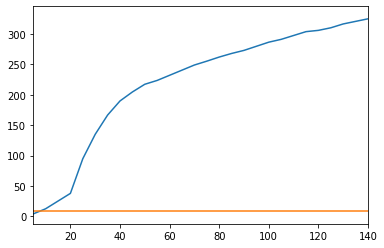

In [491]:
thresh=0.96
FWHM = corrf.apply(lambda x:x.index[np.where(x>thresh)[0][-1]]-x.index[np.where(x>thresh)[0][0]], axis=0)
plt.plot(FWHM.index[:-1],FWHM.values[:-1])
plt.plot([FWHM.index[0],FWHM.index[-2]],[FWHM.values[-1]]*2)
plt.xlim(5,140)

In [478]:
corrf.apply(lambda x:x.index[np.where(x>thresh)[0][-1]], axis=0)

5        61.185234
10      301.464638
15      339.368280
20      377.262329
25      389.891547
30      406.728848
35      413.463238
40      417.251199
45      419.355581
50      420.618196
55      421.880800
60      425.247692
65      427.772811
70      429.877045
75      431.139571
80      431.981249
85      432.822922
90      434.506255
95      435.768741
100     440.397769
105     442.501825
110     442.501825
115     444.185049
120     446.289052
125     448.813816
130     450.917754
135     453.021662
140     454.704767
145     456.808622
salt    465.223747
dtype: float64

In [477]:
FWHM

5        120.284341
10       603.536790
15       694.312774
20       787.213826
25       818.888627
30       861.123799
35       880.558736
40       897.048318
45       905.503913
50       908.883659
55       914.380614
60       921.981977
65       928.741687
70       937.198030
75       940.577985
80       943.537123
85       948.613804
90       954.532264
95       957.912360
100      966.776695
105      970.998449
110      975.233935
115      976.917159
120      981.138949
125      985.781532
130      990.003317
135      992.107225
140      995.908208
145     1002.247908
salt    1000.073645
dtype: float64